In [1]:
import  numpy as np 
import sunpy 
import glob
import os
from sunpy.map import Map
import astropy.units as u
from sunpy.net import Fido, attrs as a
from astropy.coordinates import SkyCoord
from datetime import  date, datetime
from astropy.time import Time

#--------------------------------
# BY F.J Ordonez A
# Email fordonezaraujo@gmail.com
#--------------------------------

In [2]:
t_0, t_f    = '2018-01-01T00:00:00.00', '2018-01-30T00:00:00.00'
date_format = "%Y-%m-%dT%H:%M:%S.%f"

Tx, Ty      = 0, 0  # arcsec
aiasq       =  1210 #arcsec
start_time  = datetime.strptime(t_0, date_format)
ends_time   = datetime.strptime(t_f, date_format)


top_right   = SkyCoord((Tx+aiasq)*u.arcsec, (Ty+aiasq)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
bottom_left = SkyCoord((Tx-aiasq)*u.arcsec, (Ty-aiasq)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
item = 171
sample_data = 725*u.hour
email= "email.gmail.com"

In [3]:
def get_query_sdo(item, bottom_left, top_right, start_time, ends_time, email, sample_data ,tracking=False):
    """
    Constructs a query to search for Solar Dynamics Observatory (SDO) data based on specified parameters.

    Parameters:
        item (int or str): The data item to search for (e.g., wavelength in Angstrom, 'hmi', 'dopplergram').
        bottom_left (tuple): Coordinates for the bottom left corner of the search area.
        top_right (tuple): Coordinates for the top right corner of the search area.
        start_time (str): Start time of the data search period.
        end_time (str): End time of the data search period.
        email (str): Email address for notification.
        sample_data (astropy.units.Quantity): Sampling interval for the data.
        tracking (bool): Whether to enable tracking (default is False).

    Returns:
        Query object for Fido search, or raises a ValueError for invalid inputs.
    """
    # Define the cadence lists for AIA
    aia_cad_12 = [94, 131, 171, 193, 211, 304, 335]
    aia_cad_24 = [1600, 1700]

    if item not in [94, 131, 171, 193, 211, 304, 335, 1600, 1700,  'hmi', 'aia', 'HMI', 'AIA', 'dopplergram', 'DOPPLERGRAM', 'Dopplergram']:
        raise ValueError("Supported methods are 'pearson' and 'ssim' only")
    
    if (f"{item}".lower() in ['hmi', 'dopplergram']) * (sample_data <45*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
    
    if (item in aia_cad_12) * (sample_data <12*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
    
    if (item in aia_cad_24) * (sample_data <24*u.second): 
        raise ValueError("The selected Sample is lower than the Instrumen Cadence")
            

    # Check if the item is in the aia_cad_12 list
    if item in aia_cad_12:
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=tracking)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Wavelength(item*u.angstrom),
            a.Sample(sample_data),
            a.jsoc.Series.aia_lev1_euv_12s,
            a.jsoc.Notify(email),
            a.jsoc.Segment.image,
            cutout)
    
    # Check if the item is in the aia_cad_12 list
    elif item in aia_cad_24:
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=tracking)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Wavelength(item*u.angstrom),
            a.Sample(sample_data),
            a.jsoc.Series('aia.lev1_uv_24s'),            
            a.jsoc.Notify(email),
            a.jsoc.Segment.image,
            cutout)
    
    # Check if the item matches 'hmi' (case insensitive)
    elif item.lower() == 'hmi':
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
        cadence = 45
        print('magnetogram, cadence:',cadence)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Sample(sample_data),
            a.jsoc.Series('hmi.M_45s'),
            a.jsoc.Notify(email),
            a.jsoc.Segment.magnetogram,
            cutout)
        
    elif item.lower() == 'dopplergram':
        cutout = a.jsoc.Cutout(bottom_left, top_right=top_right, tracking=True)
        cadence = 45
        print('dopplergram, cadence:',cadence)
        query = Fido.search(
            a.Time(start_time, ends_time),
            a.Sample(sample_data),
            a.jsoc.Series('hmi.v_45s'),
            a.jsoc.Notify(email),
            a.jsoc.Segment.dopplergram,
            cutout)
    else:
        # Handle the case where the item is not in any list
        query = None
        print('Please check the provided information')
    
    return query


In [4]:
query_result = get_query_sdo(item, bottom_left, top_right, start_time, ends_time, email, sample_data ,tracking=False)

In [5]:
query_result

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2017-12-31T23:59:59Z,SDO/AIA,AIA_3,171,2199


In [6]:
file_download = Fido.fetch(query_result, path='test_data/')

Export request pending. [id=JSOC_20240604_000439, status=2]
Waiting for 0 seconds...
1 URLs found for download. Full request totalling 11MB


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2018-01-01 00:00:09
Exposure Time,2.000161 s
Dimension,[4037. 4037.] pix
Coordinate System,helioprojective
Scale,[0.59948897 0.59948897] arcsec / pix
Reference Pixel,[2018.48999 2018.43005] pix

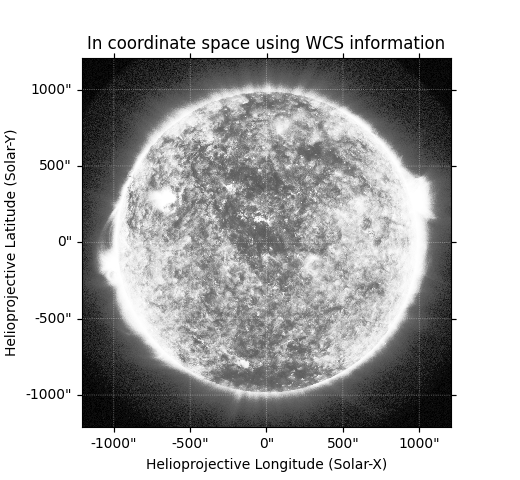
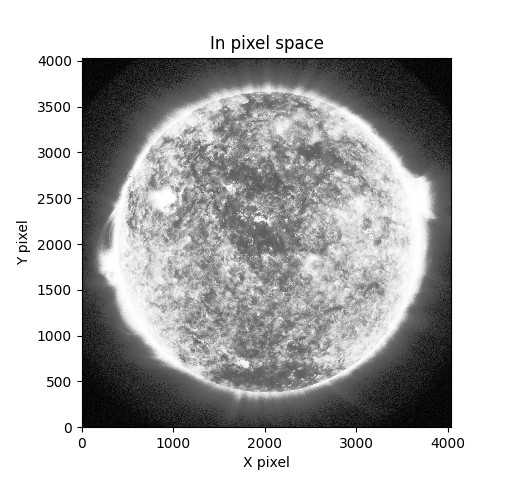
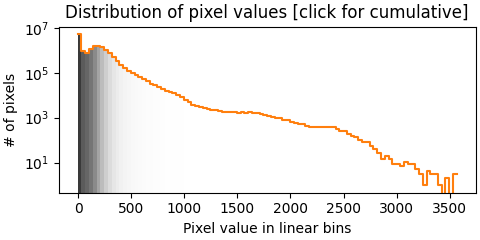
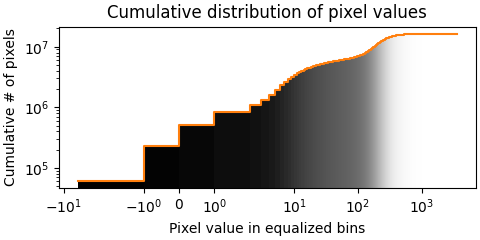

In [7]:
sunpy.map.Map("test_data/aia.lev1_euv_12s.2017-12-31T235959Z.171.image.fits")